In [114]:
import sqlite3
import pandas as pd

# Pad naar de SQLite-database
db_path = 'C:/Users/shba/Documents/JADS project/ENEXIS/src/data/WARP.db'

# Maak verbinding met de database
conn = sqlite3.connect(db_path)

# Lees de 'raw_entsoe_obs'-tabel in een Pandas DataFrame
query = "SELECT * FROM master_warp"
df = pd.read_sql_query(query, conn)

# Sluit de verbinding
conn.close()


In [117]:
print(df.columns)

Index(['Price', 'target_datetime', 'Load', 'shortwave_radiation',
       'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation',
       'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin',
       'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover',
       'weekday_sin', 'hour_sin', 'weekday_cos', 'Timestamp'],
      dtype='object')


In [118]:
df['Timestamp'] = pd.to_datetime(df['target_datetime'],utc=True)


In [178]:
from sklearn.ensemble import RandomForestRegressor

# Feature engineering
df = df.dropna()

# Example: make the comparison timestamp UTC-aware
train_start = pd.Timestamp('2025-01-01', tz='UTC')
train_end = pd.Timestamp('2025-03-14 23:59:59', tz='UTC')
test_start = pd.Timestamp('2025-03-15', tz='UTC')
test_end = pd.Timestamp('2025-03-21 23:59:59', tz='UTC')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

# Features voor het model
features = [
    'yearday_sin', 'yearday_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos'
]

X_train = train[features]
y_train = train['Price']
X_test = test[features]
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.03360203273809525
RMSE: 0.047788225619443354


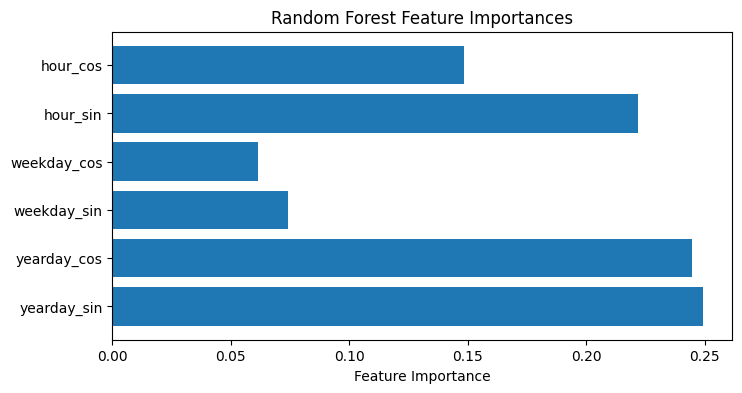

In [149]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

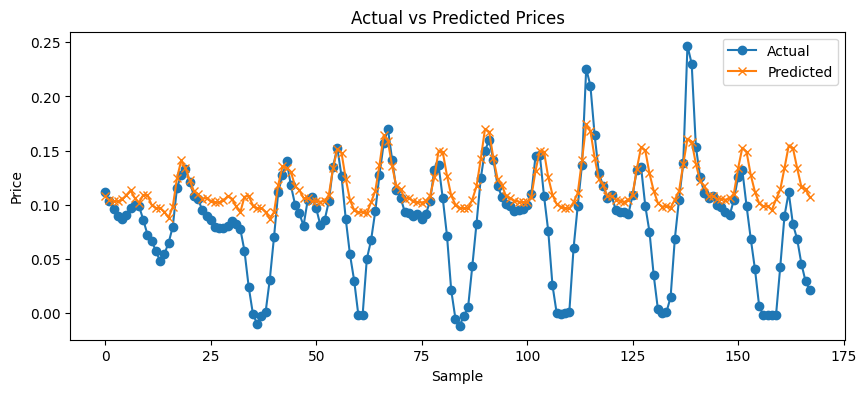

In [129]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.show()

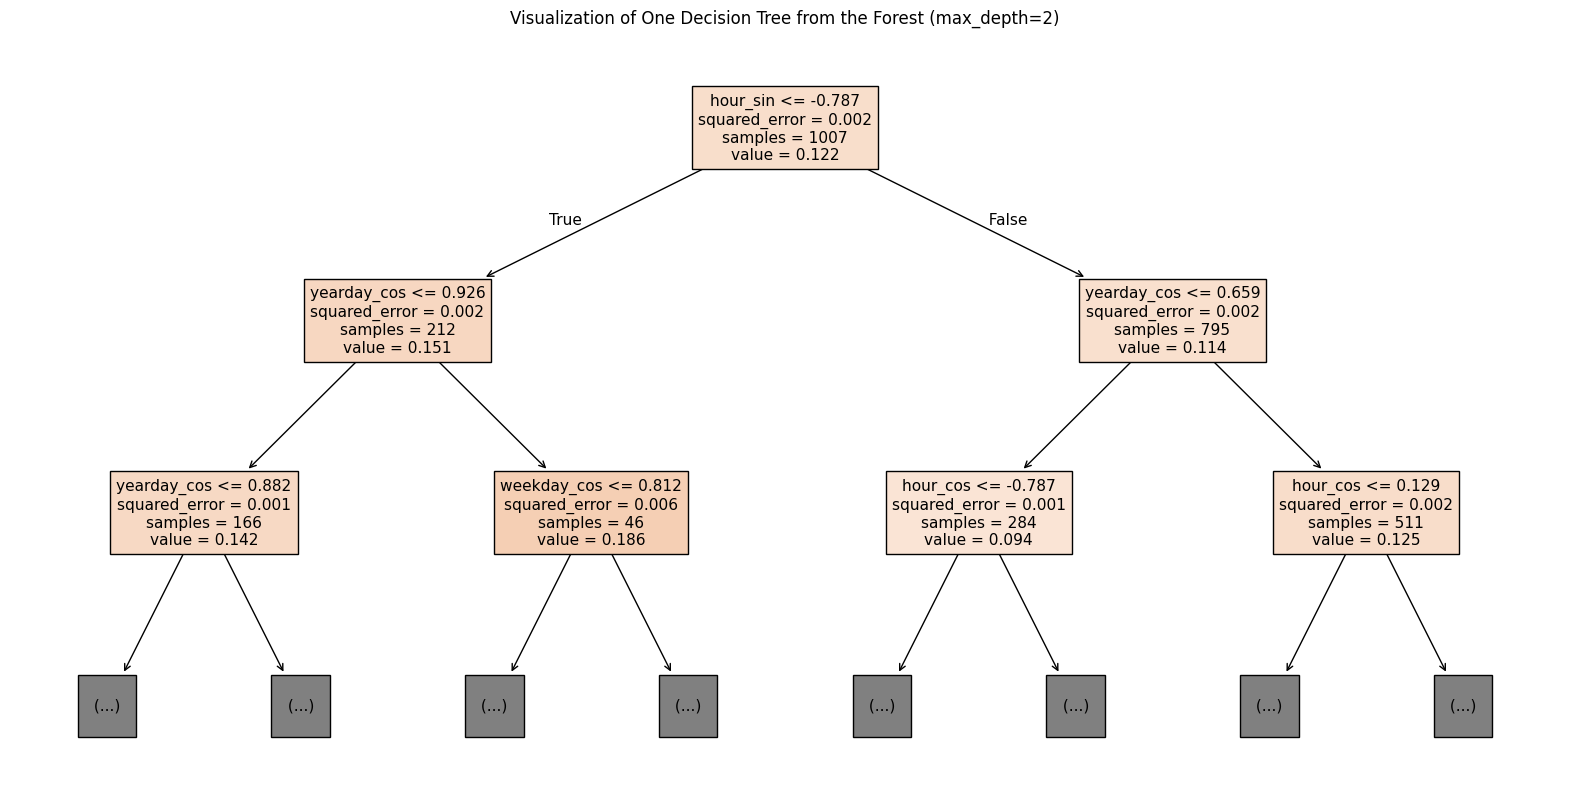

In [150]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=feature_names, filled=True, max_depth=2)
plt.title("Visualization of One Decision Tree from the Forest (max_depth=2)")
plt.show()

Index(['Price', 'Load', 'shortwave_radiation', 'temperature_2m',
       'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO',
       'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin',
       'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover',
       'weekday_sin', 'hour_sin', 'weekday_cos', 'Timestamp', 'Load_lag168',
       'Flow_NO_lag168', 'Flow_GB_lag168'],
      dtype='object')
Train: 2025-01-01 to 2025-03-14, Test: 2025-03-15 to 2025-03-21, RMSE: 0.02
Train: 2025-01-02 to 2025-03-15, Test: 2025-03-16 to 2025-03-22, RMSE: 0.03
Train: 2025-01-03 to 2025-03-16, Test: 2025-03-17 to 2025-03-23, RMSE: 0.03
Train: 2025-01-04 to 2025-03-17, Test: 2025-03-18 to 2025-03-24, RMSE: 0.03
Train: 2025-01-05 to 2025-03-18, Test: 2025-03-19 to 2025-03-25, RMSE: 0.03
Train: 2025-01-06 to 2025-03-19, Test: 2025-03-20 to 2025-03-26, RMSE: 0.03
Train: 2025-01-07 to 2025-03-20, Test: 2025-03-21 to 2025-03-27, RMSE: 0.03
Train: 2025-01-08 to 2025-03-21, Test: 2025-03-22 to 202

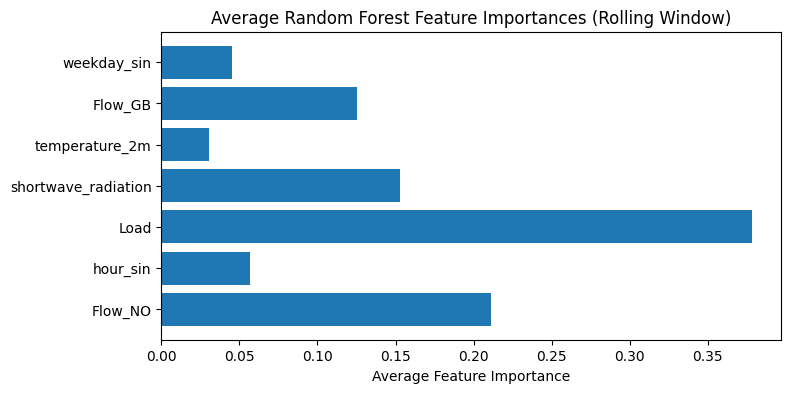

In [179]:
# Controleer kolommen
print(df.columns)
all_preds = []
all_actuals = []
all_timestamps = []
all_horizons = []

# Feature engineering
df = df.dropna()

# Parameters
window_size = 73  # days in training set
test_size = 7    # days in test set
step_size = 1    # days to roll forward
features = [
    'Flow_NO',  'hour_sin', 
    'Load','shortwave_radiation', 'temperature_2m', 
    'Flow_GB', 'weekday_sin'
] # excluded: 'yearday_sin','weekday_cos', 'diffuse_radiation', 'yearday_cos' 'hour_cos', 'month','is_dst','is_non_working_day', 'is_weekend','cloud_cover','direct_normal_irradiance',


# Prepare
df = df.sort_values('Timestamp').reset_index(drop=True)
start_date = pd.Timestamp('2025-01-01', tz='UTC')
end_date = pd.Timestamp('2025-01-31', tz='UTC')

rmses = []
maes = []
importances = []

current_start = start_date

while current_start <= end_date:
    train_start = current_start
    train_end = train_start + pd.Timedelta(days=window_size - 1, hours=23)
    test_start = train_end + pd.Timedelta(hours=1)
    test_end = test_start + pd.Timedelta(days=test_size - 1, hours=23)
    
    train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
    test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]
    
    if len(train) == 0 or len(test) == 0:
        current_start += pd.Timedelta(days=step_size)
        continue
    
    X_train = train[features]
    y_train = train['Price']
    X_test = test[features]
    y_test = test['Price']
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate horizon (days ahead) for each prediction in this test set
    horizons = ((test['Timestamp'] - test_start).dt.days).values
    
    all_preds.extend(y_pred)
    all_actuals.extend(y_test.values)
    all_timestamps.extend(test['Timestamp'].values)
    all_horizons.extend(horizons)

#Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    rmses.append(rmse)
    maes.append(mae)
    importances.append(model.feature_importances_)
    
    print(f"Train: {train_start.date()} to {train_end.date()}, Test: {test_start.date()} to {test_end.date()}, RMSE: {rmse:.2f}")
    
    current_start += pd.Timedelta(days=step_size)

# Now, build a DataFrame with the horizon included
result_df = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual': all_actuals,
    'Predicted': all_preds,
    'Horizon': all_horizons
})

# Pivot so each horizon is a column
pivot_df = result_df.pivot_table(index='Timestamp', columns='Horizon', values='Predicted', aggfunc='first')
pivot_df.columns = [f'Predicted_{int(h+1)}d_ahead' for h in pivot_df.columns]  # 1-based
pivot_df = pivot_df.reset_index()

print(pivot_df.head())

# Add actuals
actuals = result_df.drop_duplicates('Timestamp')[['Timestamp', 'Actual']]
pivot_df = pd.merge(pivot_df, actuals, on='Timestamp', how='left')

print(pivot_df.head())

# Gemiddelde RMSE, MAE en feature importance
print(f"\nAverage RMSE: {np.mean(rmses):.2f}")
print(f"Average MAE: {np.mean(maes):.2f}")

avg_importance = np.mean(importances, axis=0)
for name, imp in zip(features, avg_importance):
    print(f"{name}: {imp:.3f}")

# Visualiseer gemiddelde feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.barh(features, avg_importance)
plt.xlabel("Average Feature Importance")
plt.title("Average Random Forest Feature Importances (Rolling Window)")
plt.show()

In [174]:
# Gemiddelde RMSE, MAE en feature importance
print(f"\nAverage RMSE: {np.mean(rmses):.4f}")
print(f"Average MAE: {np.mean(maes):.4f}")


Average RMSE: 0.0291
Average MAE: 0.0216


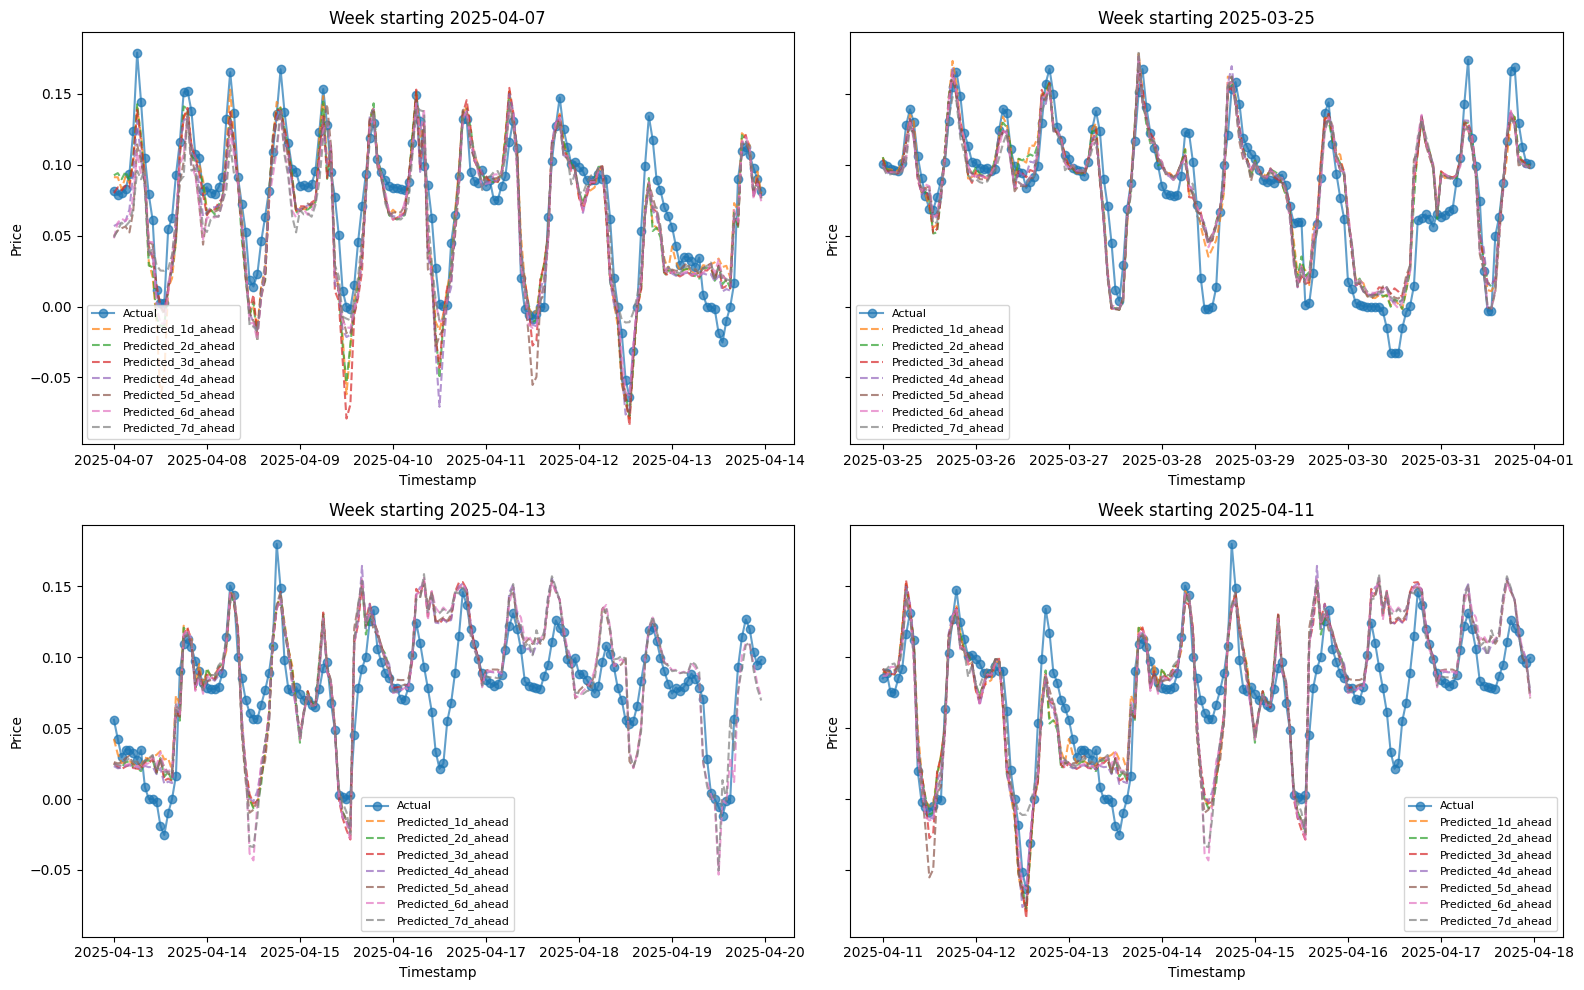

In [161]:
import matplotlib.pyplot as plt
import numpy as np

pivot_df['Timestamp'] = pd.to_datetime(pivot_df['Timestamp'])

unique_days = pivot_df['Timestamp'].dt.normalize().unique()
if len(unique_days) < 4:
    print("Niet genoeg weken in de data om 4 snapshots te maken.")
else:
    # np.random.seed(42)  # Remove this line for different random weeks each run
    chosen_starts = np.random.choice(unique_days[:-6], 4, replace=False)

    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
    axs = axs.flatten()

    for i, start_day in enumerate(chosen_starts):
        mask = (pivot_df['Timestamp'] >= start_day) & (pivot_df['Timestamp'] < start_day + np.timedelta64(7, 'D'))
        week_df = pivot_df[mask]

        ax = axs[i]
        ax.plot(week_df['Timestamp'], week_df['Actual'], label='Actual', marker='o', linestyle='-', alpha=0.7)
        for col in week_df.columns:
            if col.startswith('Predicted_'):
                ax.plot(week_df['Timestamp'], week_df[col], label=col, linestyle='--', alpha=0.7)
        ax.set_title(f"Week starting {pd.to_datetime(start_day).date()}")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Price")
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

# Calculate RMSE per horizon
rmse_per_horizon = result_df.groupby('Horizon').apply(
    lambda g: np.sqrt(np.mean((g['Actual'] - g['Predicted'])**2))
)

# Print nicely
for h, rmse in rmse_per_horizon.items():
    print(f"Average RMSE for {int(h)+1} days ahead: {rmse:.4f}")

Average RMSE for 1 days ahead: 0.0262
Average RMSE for 2 days ahead: 0.0284
Average RMSE for 3 days ahead: 0.0300
Average RMSE for 4 days ahead: 0.0305
Average RMSE for 5 days ahead: 0.0314
Average RMSE for 6 days ahead: 0.0319
Average RMSE for 7 days ahead: 0.0318


C:\Users\shba\AppData\Local\Temp\ipykernel_12776\1407637168.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_horizon = result_df.groupby('Horizon').apply(


In [177]:
# exact dezelfde code als Twan (XGBoost)

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Feature and target setup
features = [
    'Flow_NO',  'hour_sin', 'hour_cos',
    'Load','shortwave_radiation', 'temperature_2m', 
    'Flow_GB', 'weekday_sin',  
    'yearday_sin',   'weekday_cos',
    'diffuse_radiation', 'yearday_cos'
] # excluded: 'month','is_dst','is_non_working_day', 'is_weekend','cloud_cover','direct_normal_irradiance',

target = 'Price'

# Safe datetime handling
if 'target_datetime' not in df.columns:
    print("'target_datetime' column not found in columns. Sorting by index instead.")
    df = df.sort_index()
else:
    df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
    df = df.set_index('target_datetime')

# Forecast settings
start_date = pd.Timestamp("2025-03-13 12:00", tz='UTC')
end_date = pd.Timestamp("2025-05-14 12:00", tz='UTC')
lag = timedelta(hours=36)
forecast_horizon = timedelta(hours=144)

# Store RMSEs
rmses = []

current_time = start_date
while current_time <= end_date:
    train_data = df[df.index < current_time]
    test_start = current_time + lag
    test_end = test_start + forecast_horizon
    test_data = df[(df.index >= test_start) & (df.index < test_end)]

    if test_data.empty:
        print(f"No test data for forecast starting at {current_time}")
        current_time += timedelta(days=1)
        continue

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    # Train and predict
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    print(f"Forecast origin: {current_time}, Predicting {test_start} to {test_end}, RMSE: {rmse:.3f}")

    current_time += timedelta(days=1)

# Summary
avg_rmse = np.mean(rmses)
print(f"\nAverage RMSE over {len(rmses)} runs: {avg_rmse:.5f}")

# Calculate average RMSE over the first 30 runs
if len(rmses) >= 30:
    avg_rmse_30 = np.mean(rmses[:30])
    print(f"Average RMSE over first 30 runs: {avg_rmse_30:.5f}")
else:
    print("Less than 30 runs available to calculate average RMSE.")

'target_datetime' column not found in columns. Sorting by index instead.


TypeError: '<' not supported between instances of 'numpy.ndarray' and 'Timestamp'

Train: 2025-01-01 to 2025-03-14, Test: 2025-03-15 to 2025-03-21, RMSE: 0.05
Train: 2025-01-02 to 2025-03-15, Test: 2025-03-16 to 2025-03-22, RMSE: 0.05
Train: 2025-01-03 to 2025-03-16, Test: 2025-03-17 to 2025-03-23, RMSE: 0.05
Train: 2025-01-04 to 2025-03-17, Test: 2025-03-18 to 2025-03-24, RMSE: 0.05
Train: 2025-01-05 to 2025-03-18, Test: 2025-03-19 to 2025-03-25, RMSE: 0.04
Train: 2025-01-06 to 2025-03-19, Test: 2025-03-20 to 2025-03-26, RMSE: 0.04
Train: 2025-01-07 to 2025-03-20, Test: 2025-03-21 to 2025-03-27, RMSE: 0.04
Train: 2025-01-08 to 2025-03-21, Test: 2025-03-22 to 2025-03-28, RMSE: 0.03
Train: 2025-01-09 to 2025-03-22, Test: 2025-03-23 to 2025-03-29, RMSE: 0.03
Train: 2025-01-10 to 2025-03-23, Test: 2025-03-24 to 2025-03-30, RMSE: 0.04
Train: 2025-01-11 to 2025-03-24, Test: 2025-03-25 to 2025-03-31, RMSE: 0.03
Train: 2025-01-12 to 2025-03-25, Test: 2025-03-26 to 2025-04-01, RMSE: 0.04
Train: 2025-01-13 to 2025-03-26, Test: 2025-03-27 to 2025-04-02, RMSE: 0.05
Train: 2025-

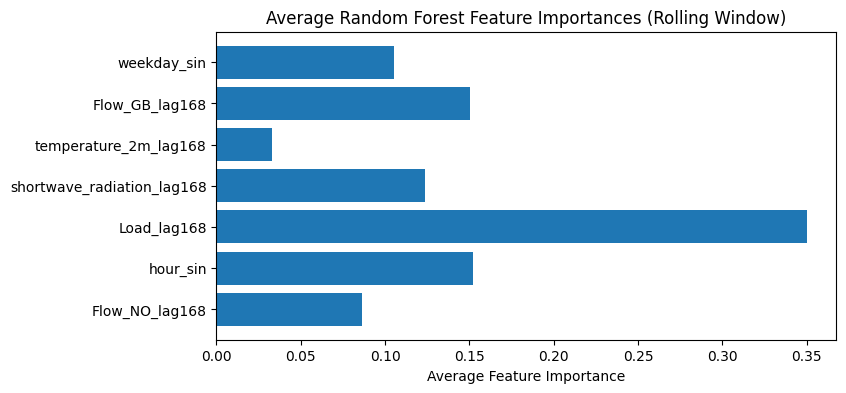

In [183]:
all_preds = []
all_actuals = []
all_timestamps = []
all_horizons = []

# Voeg een 7-daagse lag toe (168 uur terug)
df['Load_lag168'] = df['Load'].shift(168)
df['Flow_NO_lag168'] = df['Flow_NO'].shift(168)
df['Flow_GB_lag168'] = df['Flow_GB'].shift(168)
df['shortwave_radiation_lag168'] = df['shortwave_radiation'].shift(168)
df['temperature_2m_lag168'] = df['temperature_2m'].shift(168)

# Parameters
window_size = 73  # days in training set
test_size = 7    # days in test set
step_size = 1    # days to roll forward
features = [
    'Flow_NO_lag168',  'hour_sin', 
    'Load_lag168','shortwave_radiation_lag168', 'temperature_2m_lag168', 
    'Flow_GB_lag168', 'weekday_sin'
] # excluded: 'yearday_sin','weekday_cos', 'diffuse_radiation', 'yearday_cos' 'hour_cos', 'month','is_dst','is_non_working_day', 'is_weekend','cloud_cover','direct_normal_irradiance',


# Prepare
df = df.sort_values('Timestamp').reset_index(drop=True)
start_date = pd.Timestamp('2025-01-01', tz='UTC')
end_date = pd.Timestamp('2025-01-31', tz='UTC')

rmses = []
maes = []
importances = []

current_start = start_date

while current_start <= end_date:
    train_start = current_start
    train_end = train_start + pd.Timedelta(days=window_size - 1, hours=23)
    test_start = train_end + pd.Timedelta(hours=1)
    test_end = test_start + pd.Timedelta(days=test_size - 1, hours=23)
    
    train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
    test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]
    
    if len(train) == 0 or len(test) == 0:
        current_start += pd.Timedelta(days=step_size)
        continue
    
    X_train = train[features]
    y_train = train['Price']
    X_test = test[features]
    y_test = test['Price']
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate horizon (days ahead) for each prediction in this test set
    horizons = ((test['Timestamp'] - test_start).dt.days).values
    
    all_preds.extend(y_pred)
    all_actuals.extend(y_test.values)
    all_timestamps.extend(test['Timestamp'].values)
    all_horizons.extend(horizons)

#Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    rmses.append(rmse)
    maes.append(mae)
    importances.append(model.feature_importances_)
    
    print(f"Train: {train_start.date()} to {train_end.date()}, Test: {test_start.date()} to {test_end.date()}, RMSE: {rmse:.2f}")
    
    current_start += pd.Timedelta(days=step_size)

# Now, build a DataFrame with the horizon included
result_df = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual': all_actuals,
    'Predicted': all_preds,
    'Horizon': all_horizons
})

# Pivot so each horizon is a column
pivot_df = result_df.pivot_table(index='Timestamp', columns='Horizon', values='Predicted', aggfunc='first')
pivot_df.columns = [f'Predicted_{int(h+1)}d_ahead' for h in pivot_df.columns]  # 1-based
pivot_df = pivot_df.reset_index()

print(pivot_df.head())

# Add actuals
actuals = result_df.drop_duplicates('Timestamp')[['Timestamp', 'Actual']]
pivot_df = pd.merge(pivot_df, actuals, on='Timestamp', how='left')

print(pivot_df.head())

# Gemiddelde RMSE, MAE en feature importance
print(f"\nAverage RMSE: {np.mean(rmses):.2f}")
print(f"Average MAE: {np.mean(maes):.2f}")

avg_importance = np.mean(importances, axis=0)
for name, imp in zip(features, avg_importance):
    print(f"{name}: {imp:.3f}")

# Visualiseer gemiddelde feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.barh(features, avg_importance)
plt.xlabel("Average Feature Importance")
plt.title("Average Random Forest Feature Importances (Rolling Window)")
plt.show()

In [184]:
# Gemiddelde RMSE, MAE en feature importance
print(f"\nAverage RMSE: {np.mean(rmses):.4f}")
print(f"Average MAE: {np.mean(maes):.4f}")


Average RMSE: 0.0377
Average MAE: 0.0279


In [165]:
import numpy as np

# Calculate RMSE per horizon
rmse_per_horizon = result_df.groupby('Horizon').apply(
    lambda g: np.sqrt(np.mean((g['Actual'] - g['Predicted'])**2))
)

# Print nicely
for h, rmse in rmse_per_horizon.items():
    print(f"Average RMSE for {int(h)+1} days ahead: {rmse:.4f}")

Average RMSE for 1 days ahead: 0.0309
Average RMSE for 2 days ahead: 0.0338
Average RMSE for 3 days ahead: 0.0334
Average RMSE for 4 days ahead: 0.0347
Average RMSE for 5 days ahead: 0.0350
Average RMSE for 6 days ahead: 0.0342
Average RMSE for 7 days ahead: 0.0342


C:\Users\shba\AppData\Local\Temp\ipykernel_12776\1407637168.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_horizon = result_df.groupby('Horizon').apply(
